# Import files

In [1]:
from Strats.PairTradingStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [3]:
# test_pairs = coint_pairs[:4]
test_cons = ['BTCUSDT', 'ETHUSDT']
print(test_cons)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_cons:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
portfolio_prices = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-07-01",
        end_date="2025-05-31"
    )

portfolio_prices

['BTCUSDT', 'ETHUSDT']
'BTCUSDT' added successfully.
'ETHUSDT' added successfully.


,timestamp,BTCUSDT,ETHUSDT
0,2024-07-01 00:00:00,62722.08,3437.02
1,2024-07-01 00:05:00,62648.49,3433.81
2,2024-07-01 00:10:00,62624.00,3435.74
3,2024-07-01 00:15:00,62682.02,3438.27
4,2024-07-01 00:20:00,62674.01,3438.29
...,...,...,...
96188,2025-05-30 23:40:00,103802.36,2518.88
96189,2025-05-30 23:45:00,104067.40,2527.38
96190,2025-05-30 23:50:00,104010.45,2528.39
96191,2025-05-30 23:55:00,103985.48,2531.34


In [ ]:
model = pair_trading(portfolio_prices.copy())
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=1)
spread

In [ ]:
test_start_date, test_end_date = "2024-10-01", "2025-05-10"

In [ ]:
stoploss = 0.05
drawdown_duration = 2880
rolling=1000
weight_method=inverse_volatility_weighting
short = False

mr_backtest = Backtest(spread.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
mr_pnl_df = mr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
mr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.000000,0.000000
1,2024-10-01 00:05:00,0.000000,0.000000
2,2024-10-01 00:10:00,0.000000,0.000000
3,2024-10-01 00:15:00,0.000000,0.000000
4,2024-10-01 00:20:00,0.000000,0.000000
...,...,...,...
63644,2025-05-09 23:40:00,-0.000153,4100.071606
63645,2025-05-09 23:45:00,-0.000939,4100.070820
63646,2025-05-09 23:50:00,-0.001938,4100.069820
63647,2025-05-09 23:55:00,-0.001938,4100.069821


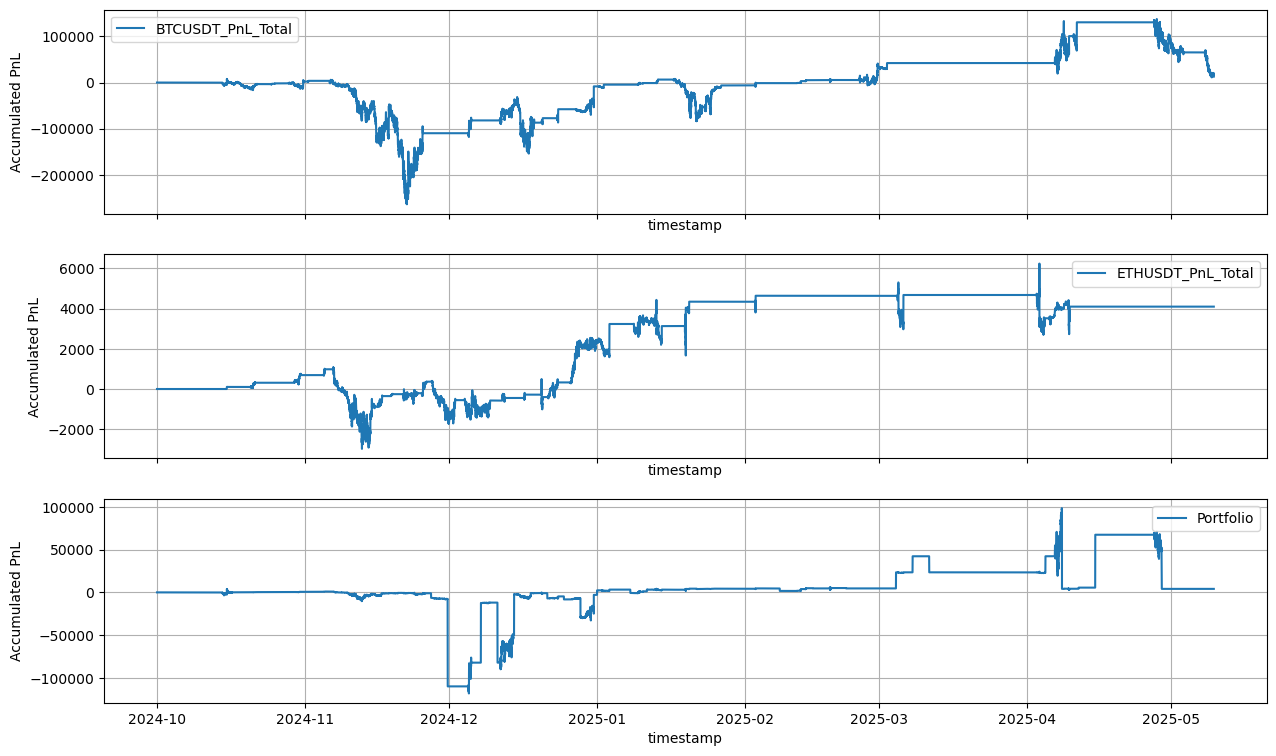

In [29]:
mr_backtest.plot_pnl(rolling=rolling, weight_method=weight_method, allow_short=short)

In [30]:
simple_strat = SimpleStrat(data=portfolio_prices)
simple_df = simple_strat.simple_strategy(lookback=12*24*3, hold_period=12*24*3)

In [31]:
simple_backtest = Backtest(simple_df.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
simple_pnl_df = simple_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
simple_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.0,0.00000
1,2024-10-01 00:05:00,0.0,0.00000
2,2024-10-01 00:10:00,0.0,0.00000
3,2024-10-01 00:15:00,0.0,0.00000
4,2024-10-01 00:20:00,0.0,0.00000
...,...,...,...
63644,2025-05-09 23:40:00,0.0,164.91427
63645,2025-05-09 23:45:00,0.0,164.91427
63646,2025-05-09 23:50:00,0.0,164.91427
63647,2025-05-09 23:55:00,0.0,164.91427


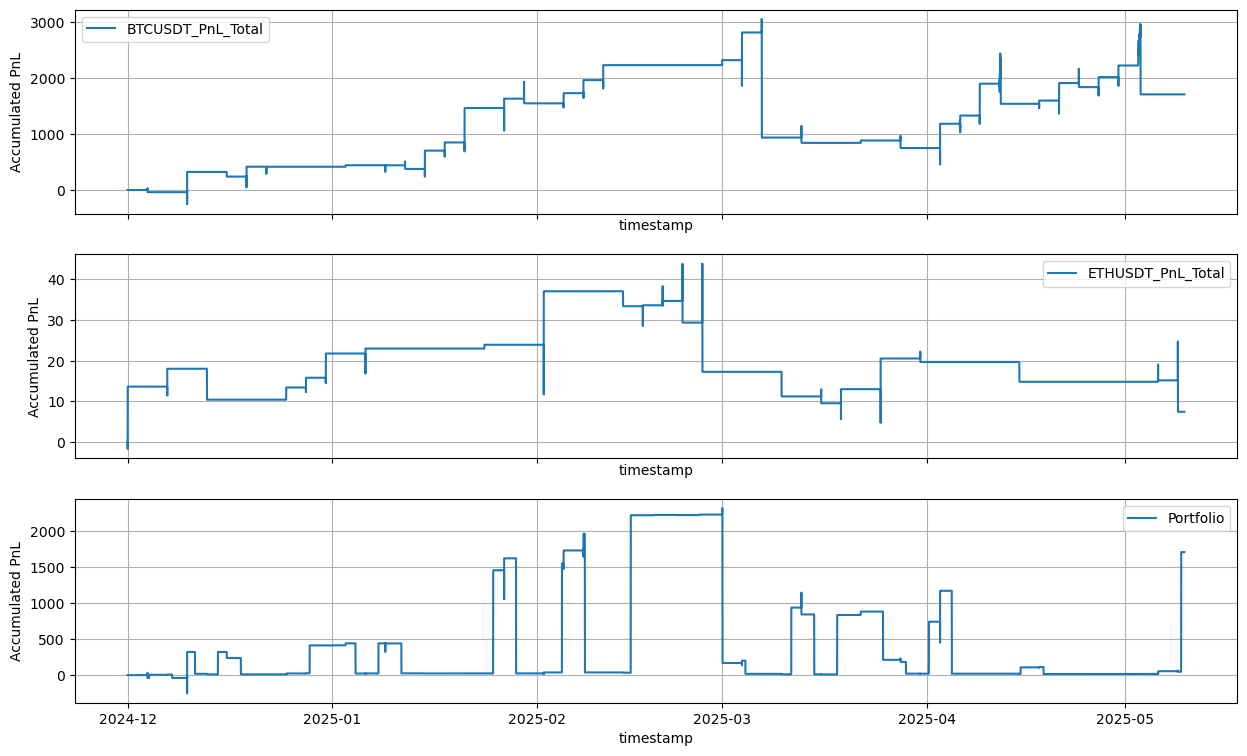

In [25]:
simple_backtest.plot_pnl(rolling=rolling, weight_method=weight_method, allow_short=short)

# Comparison

In [32]:
mr_returns = mr_backtest.get_returns(notional = 10e6, rolling=rolling, weight_method=weight_method, allow_short=short)
momentum_returns = simple_backtest.get_returns(notional = 10e6, rolling=rolling, weight_method=weight_method, allow_short=short)

returns = pd.DataFrame()
returns["Simple"] = momentum_returns
returns["MeanRevert"] = mr_returns

port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Simple               0.000019               0.000442      0.042591   
MeanRevert           0.000194               0.023354      0.020019   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio   Skewness  \
Simple                      58590     -0.000221      0.084672  -3.917745   
MeanRevert                  58590     -0.012191      0.015934 -37.343433   

               Kurtosis      VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Simple      2387.042436 -6.812011e-07  -0.000026    0.988845     1.012082  
MeanRevert  6986.410876 -6.812011e-07  -0.000028    0.988845     1.002304  


In [13]:
wrc = WhiteRealityCheck(strategies=returns["MeanRevert"], benchmark=returns["Simple"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.503
consistent    0.614
upper         0.614
dtype: float64
Superior strategy indices:
[]


[]